In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARW_pow2', None)
from ARW_pow2 import *

In [16]:
alpha =0.1; delta = 0.1; gamma=1
num_periods = 1000
num_trials = 2

#NOTE: uncomment to change shift patterns
#beta_1 = np.sin(np.linspace(0, 3*np.pi, num_periods)) + 5
#beta_1 = np.ones(num_periods)
beta_1 = generate_true_means(num_periods-1, 2)
beta_2 = np.ones(num_periods)
#plt.plot(beta_1)
#plt.show()
beta = np.column_stack((beta_1, beta_2))
variance_y = 1; meanX = 1

np.random.seed(6)

#B_arr is for val set
B_arr = np.random.randint(low=2, high=5, size=num_periods)
B_arr_starts = np.arange(num_periods)
B_arr_ends = np.cumsum(B_arr) - 1

#for training set
B_arr_tr = 10 * B_arr

#NOTE: all the above can be tuned

fixed_windows = [1, 4, 16, 64, 256, 1024]

err_dict = {}
err_dict['ARW'] = {}
for k in fixed_windows:
    err_dict[f'Val_{k}'] = {}
    for trial in range(num_trials):
        err_dict[f'Val_{k}'][trial] = []
        err_dict['ARW'][trial] = []

seeds = np.arange(num_trials) + 2024

for (trial, seed) in tqdm(enumerate(seeds)):
    
    np.random.seed(seed)

    X_tr, y_tr = generate_linreg_data(meanX, B_arr_tr, beta, variance_y)
    X_val, y_val = generate_linreg_data(meanX, B_arr, beta, variance_y)

    k_hat_all = []
    for t in range(num_periods):
        
        idx = B_arr_ends[t]+1

        reg, S_t = fit_and_get_scores(X_tr[:idx], y_tr[:idx], X_val[:idx], y_val[:idx])

        B_arr_t = B_arr[:t+1]

        khat, qt_khat, qtk_all = ARWQE(S_t, B_arr_t, alpha, delta, gamma)
        k_hat_all.append(khat)
        beta_t = beta[t]

        #compute coverage
        dimX = X_tr.shape[1]

        #approximate by generating ~1000 X, Y from this period 
        # and calculate coverage of prediction set
        X_test = generate_multinomial_X(meanX, dimX, 1000)
        y_hat = reg.predict(X_test)

        mu_test = X_test @ beta[t].T
        Y_test = mu_test + np.random.normal(0, variance_y, 1000)  

        coverage_ARW = monte_carlo_coverage(y_hat, qt_khat, Y_test)
        err_dict['ARW'][trial].append(np.abs(coverage_ARW - 1+alpha))

        #baseline: take quantile of fixed k
        #qtk_fixed = compute_qtk(S_t, np.array(fixed_windows), B_arr_t, alpha)
        for ik, k in enumerate(fixed_windows):
            log2k = int(np.log2(k))
            qtk = qtk_all[min(log2k, len(qtk_all)-1)]
            coverage_k = monte_carlo_coverage(y_hat, qtk, Y_test)
            err_dict[f'Val_{k}'][trial].append(np.abs(coverage_k - 1+alpha))
    
    #plot k_hat_all
    #plt.plot(k_hat_all)

2it [00:02,  1.47s/it]


['ARW', 'Val_1', 'Val_4', 'Val_16', 'Val_64', 'Val_256', 'Val_1024']
[0.01182167 0.18416444 0.07829889 0.03664333 0.01852444 0.01104722
 0.011445  ]


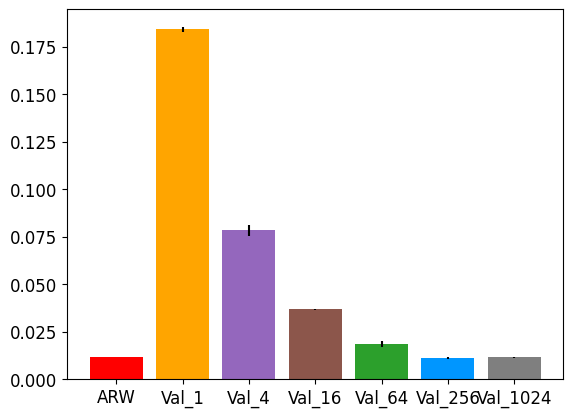

In [17]:
#process results in err_dict
methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
print(methods)
num_methods = len(methods)
err_array = np.zeros((len(methods), num_trials, num_periods))
for (i, key) in enumerate(err_dict.keys()):
    for (trial, trial_coverage) in err_dict[key].items():
        err_array[i, trial, :] = trial_coverage
#take average of coverage over time and trials for each method
mean_error = np.mean(np.mean(err_array[:, :, 100:], axis=2), axis=1)
std_error = np.std(np.mean(err_array[:, :, 100:], axis=2), axis=1)
fig, ax = plt.subplots()
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', 'tab:gray']
for i in range(num_methods):
    ax.bar(methods[i], mean_error[i], yerr=std_error[i], color=colors[i])
print(mean_error)

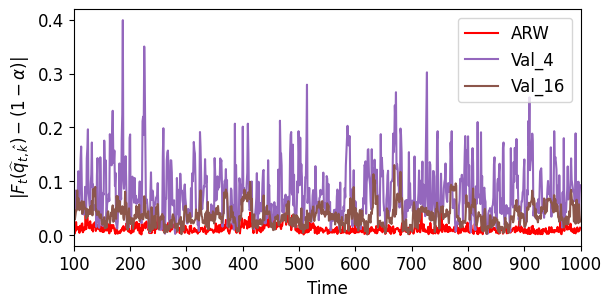

In [18]:
#plot cdf over time periods for ARW, V1, V256
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', 'tab:gray']
methods = ['ARW', 'Val_1', 'Val_4', 'Val_16', 'Val_64', 'Val_256', 'Val_1024']

#NOTE: uncomment to change the index of the methods to plot
methods_to_plot = [0, 2,3]

err_over_trials = np.mean(err_array[:, :, :], axis=1)

fig, ax = plt.subplots(1, 1, figsize = (6,3))
for method in methods_to_plot:
    plt.plot(err_over_trials[method], color=colors[method], label=methods[method])

#ignore everything before 100
plt.xlim(100, num_periods)

#figure settings
mpl.rcParams.update({'font.size': 12})
plt.tight_layout()
plt.ylabel(r'$|F_t(\widehat{q}_{t,\hat{k}})-(1-\alpha)|$')
plt.xlabel('Time')


#uncomment to show legend and save the figure

plt.legend()
#plt.savefig(f'{DATAPATH}/{figname}_time_var{variance}.png', dpi=300, bbox_inches='tight')
